In [14]:
import scipy.io
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import hypers as hp
import tensorly
from tensorly import unfold
from numpy import linalg
from scipy.spatial import distance
import itertools

In [15]:
def perms(x):
    return np.vstack(list(itertools.permutations(x)))[::-1]

In [16]:
def HyperRmse(abundance,realAbundance,sor):
    imageSize=realAbundance.shape[0];
    x=np.sqrt(np.sum((realAbundance-abundance[:,sor.astype(int)-1])**2,0)/imageSize)
    result=x.mean(axis=0)
    return result

In [17]:
def cosDistance(res,original):
    [row,col]=[res.shape[0],res.shape[1]]
    meanDistance=np.Inf
    p=perms(np.linspace(1,col,col))
    num=p.shape[0]
    sadMat=np.zeros((col,col))
    for i in range(col):
        temp=res[:,i]
        temp=np.reshape(temp,(temp.shape[0],1))
        temp=np.tile(temp, (1, col))
        sadMat[i,:]=np.arccos(np.sum(temp.conj()*original, axis=0)/(np.sqrt(np.diag(temp.T@temp))*np.sqrt(np.diag(original.T@original))).T) 
    sadMat=sadMat.T
    meanDistance=np.Inf
    temp1=np.zeros(col)
    for i in range(num):
        for j in range(col):
            #print(int(p[i,j]))
            temp1[j] = sadMat[j,int(p[i,j])-1]
        if temp1.mean(axis=0)<meanDistance:
            sor=p[i,:]
            meanDistance=temp1.mean(axis=0)
            Distance=temp1
    return meanDistance,Distance,sor
    

In [18]:
def sumRank(rankVector,i):
    result=0;
    for j in range(0,i):
        result=result+rankVector[0,j]
    
    return result

In [19]:
def calculatesparsity(abundance):
    endmembNum=abundance.shape[1]
    imageSize=abundance.shape[0]
    total=0
    for i in range(endmembNum):
        normDiv=np.linalg.norm(abundance[:,i],1)/np.linalg.norm(abundance[:,i],2)
        total= total + (np.sqrt(imageSize)-normDiv)/(np.sqrt(imageSize)-1)
    result=total/np.sqrt(endmembNum)
    
    return result

In [20]:
def normAbundance(btdRes,massNum,L):
    rankVector=np.ones((1,massNum))*L
    abundanceRes=np.zeros((btdRes[0].shape[0],btdRes[0].shape[0],massNum))
    for i in range(1,massNum+1):
        ind=np.linspace(int(sumRank(rankVector,i-1)),int(sumRank(rankVector,i))-1,int(sumRank(rankVector,i))-int(sumRank(rankVector,i-1)))
        ind=ind.astype(int)
        W=btdRes[0][:,ind]
        #print(W.shape)
        #print(W)
        H=btdRes[1][:,ind]
        #print(H.shape)
        abundanceRes[:,:,i-1]=H@W.T
        #print(abundanceRes[:,:,i-1])
    [width,length,height]=[abundanceRes.shape[0],abundanceRes.shape[1],abundanceRes.shape[2]];
    abundanceRes=np.reshape(abundanceRes,(width*length,massNum));
    temp=width*length; 
    return abundanceRes
    

In [21]:
def partitionedKhatriRao(mat1,mat2,mat1_part,mat2_part):
    #mat1=C
    #mat2=B
    #mat1_part=np.ones((1,R))
    #mat2_part=np.ones((1,R))*L
    [J,M]=[mat1.shape[0],mat1.shape[1]]
    [K,N]=[mat2.shape[0],mat2.shape[1]]
    num_part=mat2_part.shape[1]
    mat1_ind=np.append([0],[np.cumsum(mat1_part)])
    mat2_ind=np.append([0],[np.cumsum(mat2_part)])
    indMat=np.append([0],[np.cumsum(mat1_part*mat2_part)])
    KhatriRao_Mat=np.zeros((J*K,int(np.sum(mat1_part*mat2_part))))
    for i in range(num_part):
        ind1=np.linspace(int(indMat[i]),int(indMat[i+1])-1,int(indMat[i+1])-int(indMat[i]))
        ind1=ind1.astype(int)
        ind2=np.linspace(int(mat1_ind[i]),int(mat1_ind[i+1])-1,int(mat1_ind[i+1])-int(mat1_ind[i]))
        ind2=ind2.astype(int)
        ind3=np.linspace(int(mat2_ind[i]),int(mat2_ind[i+1])-1,int(mat2_ind[i+1])-int(mat2_ind[i]))
        ind3=ind3.astype(int)
        KhatriRao_Mat[:,ind1]=np.kron(mat1[:,ind2] ,mat2[:,ind3])
    return KhatriRao_Mat

In [22]:
def btdunmixing(X,R,L,A,B,C,delt,lambd): 
    [I,J,K]=[X.shape[0],X.shape[1],X.shape[2]]
    X1= unfold(X.T,2)
    X2= unfold(X.T,1)
    X3=unfold(X.T,0)
    Ps=np.kron(np.eye(R),np.ones((L,1)))
    KhatriRao_Mat=partitionedKhatriRao(C,B,np.ones((1,R)),np.ones((1,R))*L)
    objnew=np.linalg.norm(X1-A@(KhatriRao_Mat.T),'fro')
    btdRes=[A,B,C]
    #print(A.shape,B.shape,C.shape)
    abundanceRes=normAbundance(btdRes,R,L)
    times=0;
    objhistory=[];
    objhistory=np.append(objhistory,objnew);
    sad=0;
    rmse=0;
    sparsity=calculatesparsity(abundanceRes.T);
    sumToOne=np.ones((I,J));
    it=1;
    while 1:
        oldEndmember=C;
        oldAbundance=abundanceRes;
        objOld=objnew;
        oldSparsity=sparsity;
        oldSad=sad;
        oldRmse=rmse;
        M=partitionedKhatriRao(C,B,np.ones((1,R)),np.ones((1,R))*L)
        A=A*((X1@M+delt*sumToOne@B)/(A@M.T@M+1e-4+delt*A@B.T@B))
        M=partitionedKhatriRao(C,A,np.ones((1,R)),np.ones((1,R))*L)
        B=B*((X2@M+delt*sumToOne.T@A)/(B@M.T@M+1e-4+delt*B@A.T@A))
        M=sp.linalg.khatri_rao(B,A)@Ps
        C=C*((X3@M)/(C@M.T@M))
        #print(C)
        objnew=0.5*np.linalg.norm(X1-A@((partitionedKhatriRao(C,B,np.ones((1,R)),np.ones((1,R))*L)).T),'fro')+0.5*delt*np.linalg.norm(sumToOne-A@B.T,'fro')
        #objhistory=np.append(objhistory,objnew)
        btdRes=[A,B,C]
        abundanceRes=normAbundance(btdRes,R,L)
        #print(abundanceRes[2,:])
        toltemp = np.abs(objOld - objnew)/objOld
        print('iter [%f]: obj [%f],sad [%f],rmse [%f],sparsity [%f] C[%f]\n ' % (it,objnew,sad,rmse,sparsity,np.linalg.norm(((C.T.flatten()).T),2)))
        [sad,allSadDistance,sor]=cosDistance(C,oldEndmember)
        rmse=HyperRmse(oldAbundance,abundanceRes,sor)
        sparsity=calculatesparsity(abundanceRes)
        if (abs(oldSparsity-sparsity)/oldSparsity<(2e-4) and abs(oldSad-sad)/oldSad<(2e-4) and abs(oldRmse-rmse)/oldRmse<(2e-4)):
                times = times + 1

        else:
            times=0
            

        it = it+1
        if (times==lambd):
            res=[C,abundanceRes,objhistory,btdRes]
            break
    return res

In [23]:
#A=r1
#B=r2
#C=r3
#A.shape,B.shape,C.shape
#R=num_endmems
#L=rnk
#X=Y
#X1= unfold(X.T,2)
#X2= unfold(X.T,1)
#X3=unfold(X.T,0)
#Ps=np.kron(np.eye(R),np.ones((L,1)))
#M=partitionedKhatriRao(C,B,np.ones((1,R)),np.ones((1,R))*L)
#A=A*((X1@M+delt*sumToOne@B)/(A@M.T@M+1e-4+delt*A@B.T@B))
#M=partitionedKhatriRao(C,A,np.ones((1,R)),np.ones((1,R))*L)
#B=B*((X2@M+delt*sumToOne.T@A)/(B@M.T@M+1e-4+delt*B@A.T@A))
#M=sp.linalg.khatri_rao(B,A)@Ps
#C=C*((X3@M)/(C@M.T@M))
#objnew=0.5*np.linalg.norm(X1-A@((partitionedKhatriRao(C,B,np.ones((1,R)),np.ones((1,R))*L)).T),'fro')+0.5*delt*np.linalg.norm(sumToOne-A@B.T,'fro')
        #objhistory=np.append(objhistory,objnew)
#btdRes=[A,B,C]
#abundanceRes=normAbundance(btdRes,R,L)

In [30]:
Data= scipy.io.loadmat('jasperRidge2_R198')
#Endmembers= scipy.io.loadmat('t_jasper_em')
Endmembers= scipy.io.loadmat('GroundTruth')
Endmembers=Endmembers["M0_VCA"]
r1=scipy.io.loadmat('r1_new')
r2=scipy.io.loadmat('r2_new')
r3=scipy.io.loadmat('r3_more')
r1=r1["r1"]
r2=r2["r2"]
r3=r3["r3"]
nBand=Data["nBand"]
nCol=Data["nCol"]
nRow=Data["nRow"]
Region= Data["Region"]
bands=np.concatenate([np.linspace(0, 98, num=99),np.linspace(104, 136, num=33),np.linspace(145, 197, num=53)])
Y=Data["Y"]
bands=bands.astype(int)
#bands= bands.tolist()
Y= Y[bands,:]
#Endmembers=Endmembers[bands,:]
Y=Y/np.max(Y)
invRC = 1; 
ind=0
Y=Y.reshape(185,100,100)
Y=Y.T
Y_hyp = hp.array(Y)
VCA_Endmembers, spcs = Y_hyp.unmix.vca.calculate(n_components=4)
[m,n,L]=[Y.shape[0],Y.shape[1],Y.shape[2]]
data_r=Y.reshape(10000,185)
Endmembers = Endmembers.astype(np.double)
Abundance_fcls = Y_hyp.abundance.fcls.calculate(Endmembers)
realAbundance=Abundance_fcls.T
num_endmems=4;
rnk=19;
delt=0.4;
lambd=5;
r1=r1[:,:rnk*num_endmems]
r2=r2[:,:rnk*num_endmems]
r3=r3[:,:num_endmems]

SNR estimated = 30.66005399667697[dB]
... Select the projective proj.


In [31]:
res= btdunmixing(Y,num_endmems,rnk,r1,r2,r3,delt,lambd)

iter [1.000000]: obj [84.014155],sad [0.000000],rmse [0.000000],sparsity [3.114447] C[17.971915]
 
iter [2.000000]: obj [83.189170],sad [0.489537],rmse [4.702595],sparsity [0.260389] C[17.868065]
 
iter [3.000000]: obj [82.794571],sad [0.005072],rmse [0.005698],sparsity [0.275027] C[17.768841]
 
iter [4.000000]: obj [82.404041],sad [0.002498],rmse [0.001918],sparsity [0.272048] C[17.672681]
 
iter [5.000000]: obj [82.001248],sad [0.002281],rmse [0.001741],sparsity [0.269469] C[17.579291]
 
iter [6.000000]: obj [81.570563],sad [0.002177],rmse [0.001619],sparsity [0.267415] C[17.488469]
 
iter [7.000000]: obj [81.096896],sad [0.002161],rmse [0.001537],sparsity [0.265780] C[17.400086]
 
iter [8.000000]: obj [80.565610],sad [0.002212],rmse [0.001493],sparsity [0.264492] C[17.314051]
 
iter [9.000000]: obj [79.963074],sad [0.002316],rmse [0.001488],sparsity [0.263504] C[17.230283]
 
iter [10.000000]: obj [79.277949],sad [0.002464],rmse [0.001521],sparsity [0.262797] C[17.148669]
 
iter [11.

In [ ]:
resu=scipy.io.loadmat('res19')
resu=resu["res"]

In [32]:
realAbundance=Abundance_fcls.T
est_endmems=res[0]
#sor=np.array([2,1,4,3])
[sad,Distance,sor]=cosDistance(est_endmems,Endmembers)
#rmse=HyperRmse(res[1],realAbundance,sor)
rmse=HyperRmse(res[1],(np.reshape(realAbundance,(realAbundance.shape[0],realAbundance.shape[1]*realAbundance.shape[2])).T),sor)

In [33]:
sor

array([2., 1., 4., 3.])

In [34]:
sad

0.29263132941423375

In [35]:
rmse

0.12710467554874896

<Figure size 900x300 with 0 Axes>

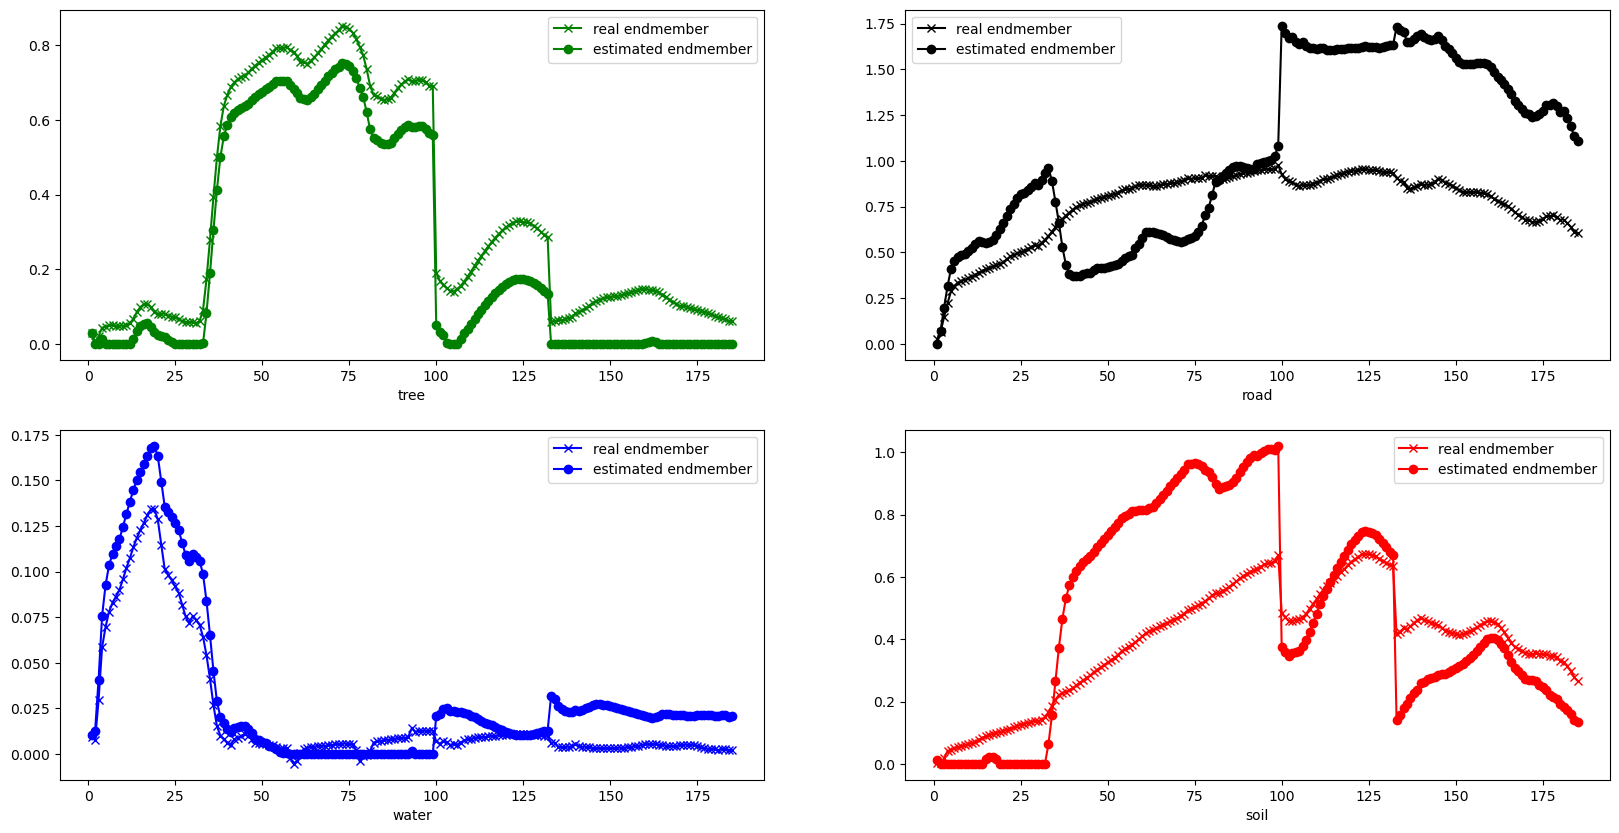

In [36]:
plt.figure(figsize=(9, 3))

fig, axs = plt.subplots(2,2,figsize=(20, 10))
#fig.suptitle('Endmember Plots')

x = np.linspace(1,185,185)

axs[0,0].plot(x,Endmembers[:,0],color='green',marker='x')
axs[0,0].plot(x,est_endmems[:,int(sor[0]-1)],color='green',marker='o')
axs[0,0].set_xlabel("tree")
axs[0,0].legend(['real endmember','estimated endmember'])
axs[0,1].plot(x,Endmembers[:,1],color='black',marker='x')
axs[0,1].plot(x,est_endmems[:,int(sor[1]-1)],color='black',marker='o')
axs[0,1].set_xlabel("road")
axs[0,1].legend(['real endmember','estimated endmember'])
axs[1,0].plot(x,Endmembers[:,2],color='blue',marker='x')
axs[1,0].plot(x,est_endmems[:,int(sor[2]-1)],color='blue',marker='o')
axs[1,0].set_xlabel("water")
axs[1,0].legend(['real endmember','estimated endmember'])
axs[1,1].plot(x,Endmembers[:,3],color='red',marker='x')
axs[1,1].plot(x,est_endmems[:,int(sor[3]-1)],color='red',marker='o')
axs[1,1].set_xlabel("soil")

axs[1,1].legend(['real endmember','estimated endmember'])

Text(0.5, 0, 'estimated abundance map of soil')

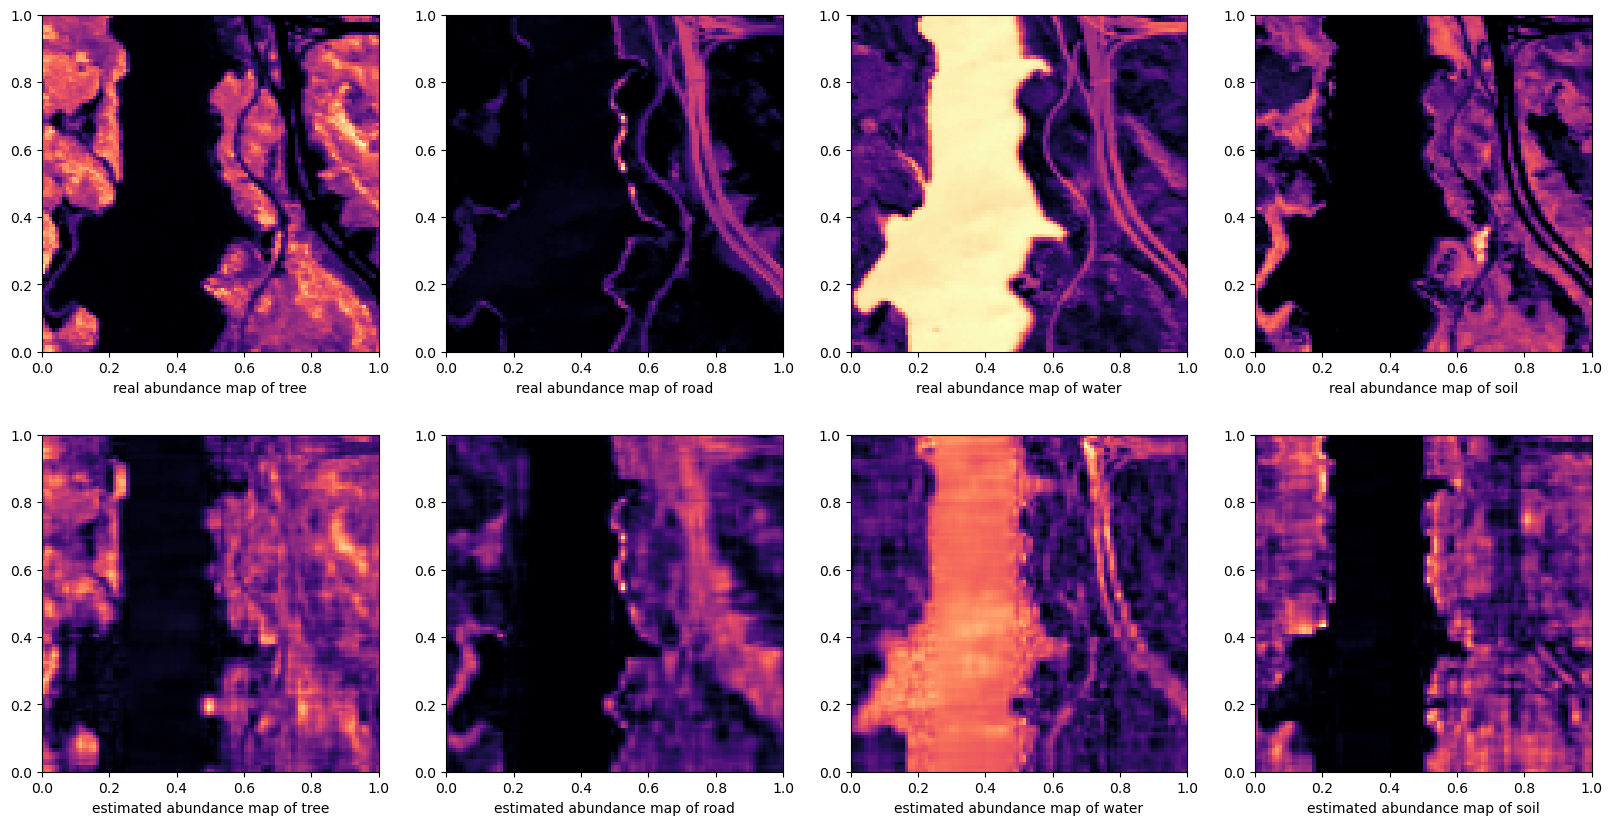

In [37]:
real_abund_tensor=realAbundance.T
est_abund_tensor=np.reshape(res[1],(int(np.sqrt(res[1].shape[0])),int(np.sqrt(res[1].shape[0])),res[1].shape[1]))
est_abund_tensor=est_abund_tensor
fig, axs = plt.subplots(2,4,figsize=(20, 10))
#fig.suptitle('Abundance Maps')
plt.set_cmap("magma")
axs[0,0].imshow(real_abund_tensor[:,:,0], extent=[0, 1, 0, 1])
axs[0,0].set_xlabel('real abundance map of tree')
axs[0,1].imshow(real_abund_tensor[:,:,1], extent=[0, 1, 0, 1])
axs[0,1].set_xlabel('real abundance map of road')
axs[0,2].imshow(real_abund_tensor[:,:,2], extent=[0, 1, 0, 1])
axs[0,2].set_xlabel('real abundance map of water')
axs[0,3].imshow(real_abund_tensor[:,:,3], extent=[0, 1, 0, 1])
axs[0,3].set_xlabel('real abundance map of soil')
axs[1,0].imshow(est_abund_tensor[:,:,int(sor[0]-1)].T, extent=[0, 1, 0, 1])
axs[1,0].set_xlabel('estimated abundance map of tree')
axs[1,1].imshow(est_abund_tensor[:,:,int(sor[1]-1)].T, extent=[0, 1, 0, 1])
axs[1,1].set_xlabel('estimated abundance map of road')
axs[1,2].imshow(est_abund_tensor[:,:,int(sor[2]-1)].T, extent=[0, 1, 0, 1])
axs[1,2].set_xlabel('estimated abundance map of water')
axs[1,3].imshow(est_abund_tensor[:,:,int(sor[3]-1)].T, extent=[0, 1, 0, 1])
axs[1,3].set_xlabel('estimated abundance map of soil')

In [38]:
def nmf_unmixing(v,w1,h1):
    s=v.shape;
    #rnk_v=np.linalg.matrix_rank(v)
    rnk_v=4
   
    num_rt=w1.T@v
    den_rt=w1.T@w1@h1
    for j in range(rnk_v):
        for k in range(s[1]):
            h1[j,k]=h1[j,k]*(num_rt[j,k]/den_rt[j,k])

    num_rt2=v@h1.T
    den_rt2=w1@h1@h1.T + e
    for j in range(s[0]):
        for k in range(rnk_v):
            w1[j,k]=w1[j,k]*(num_rt2[j,k]/den_rt2[j,k])
    return h1,w1



In [39]:
Data= scipy.io.loadmat('jasperRidge2_R198')
#Endmembers= scipy.io.loadmat('t_jasper_em')
Endmembers= scipy.io.loadmat('GroundTruth')
Endmembers=Endmembers["M0_VCA"]
r1=scipy.io.loadmat('r1_new')
r2=scipy.io.loadmat('r2_new')
r3=scipy.io.loadmat('r3_more')
r1=r1["r1"]
r2=r2["r2"]
r3=r3["r3"]
nBand=Data["nBand"]
nCol=Data["nCol"]
nRow=Data["nRow"]
Region= Data["Region"]
bands=np.concatenate([np.linspace(0, 98, num=99),np.linspace(104, 136, num=33),np.linspace(145, 197, num=53)])
Y=Data["Y"]
bands=bands.astype(int)
#bands= bands.tolist()
Y= Y[bands,:]
#Endmembers=Endmembers[bands,:]
Y=Y/np.max(Y)
v=Y
s=v.shape
delt=0.4;
#lambd=5;
rnk_v=np.linalg.matrix_rank(v)
rnk_v=4
e_nmf=np.random.rand(s[0],rnk_v)
a_nmf=np.random.rand(rnk_v,s[1])
e = 1.0e-10
objnew=0.5*np.linalg.norm(v-e_nmf@a_nmf,'fro')
times=0;
objhistory=[];
objhistory=np.append(objhistory,objnew);
sad=0;
rmse=0;
sparsity=calculatesparsity(a_nmf.T);
sumToOne=np.ones((int(np.sqrt(s[1])),int(np.sqrt(s[1]))));
it=1;
for i in range(1000):
    oldEndmember=e_nmf;
    oldAbundance=a_nmf.T;
    objold=objnew;
    oldSparsity=sparsity;
    oldSad=sad;
    oldRmse=rmse;
    a_nmf,e_nmf =nmf_unmixing(Y,e_nmf,a_nmf)
    objnew=0.5*np.linalg.norm(v-e_nmf@a_nmf,'fro')
    objhistory=np.append(objhistory,objnew)
    print('iter [%f]: obj [%f],sad [%f],rmse [%f],sparsity [%f]\n ' % (it,objnew,sad,rmse,sparsity))
    [sad,allSadDistance,sor]=cosDistance(e_nmf,oldEndmember)
    rmse=HyperRmse(oldAbundance,a_nmf.T,sor)
    sparsity=calculatesparsity(a_nmf.T)
    if (abs(oldSparsity-sparsity)/oldSparsity<2e-4 and abs(oldSad-sad)/oldSad<(2e-4) and abs(oldRmse-rmse)/oldRmse<(2e-4)):
                times = times + 1
    else:
            times=0

    it = it+1
    if (times==lambd):
        res=[e_nmf,a_nmf]
        break



iter [1.000000]: obj [58.280592],sad [0.000000],rmse [0.000000],sparsity [0.271077]
 
iter [2.000000]: obj [54.283158],sad [0.376607],rmse [0.051454],sparsity [0.501552]
 


C:\Users\sinji\AppData\Local\Temp\ipykernel_15768\4289614265.py:11: RuntimeWarning: invalid value encountered in arccos
  sadMat[i,:]=np.arccos(np.sum(temp.conj()*original, axis=0)/(np.sqrt(np.diag(temp.T@temp))*np.sqrt(np.diag(original.T@original))).T)


iter [3.000000]: obj [52.802489],sad [0.404160],rmse [0.048395],sparsity [0.498869]
 
iter [4.000000]: obj [51.653745],sad [0.352184],rmse [0.047411],sparsity [0.483895]
 
iter [5.000000]: obj [50.725360],sad [0.000000],rmse [0.000000],sparsity [0.471173]
 
iter [6.000000]: obj [49.942679],sad [0.000000],rmse [0.000000],sparsity [0.460512]
 
iter [7.000000]: obj [49.250251],sad [0.000000],rmse [0.000000],sparsity [0.451525]
 
iter [8.000000]: obj [48.603080],sad [0.000000],rmse [0.000000],sparsity [0.443933]
 
iter [9.000000]: obj [47.960881],sad [0.328682],rmse [0.037725],sparsity [0.437550]
 
iter [10.000000]: obj [47.284189],sad [0.302223],rmse [0.039000],sparsity [0.432262]
 
iter [11.000000]: obj [46.531897],sad [0.306172],rmse [0.038019],sparsity [0.428013]
 
iter [12.000000]: obj [45.660384],sad [0.000000],rmse [0.000000],sparsity [0.424800]
 
iter [13.000000]: obj [44.624925],sad [0.464563],rmse [0.055407],sparsity [0.422660]
 
iter [14.000000]: obj [43.384343],sad [0.600146],r

C:\Users\sinji\AppData\Local\Temp\ipykernel_15768\1339262344.py:54: RuntimeWarning: invalid value encountered in double_scalars
  if (abs(oldSparsity-sparsity)/oldSparsity<2e-4 and abs(oldSad-sad)/oldSad<(2e-4) and abs(oldRmse-rmse)/oldRmse<(2e-4)):


iter [143.000000]: obj [8.797524],sad [0.000000],rmse [0.000000],sparsity [0.432139]
 
iter [144.000000]: obj [8.769745],sad [0.674161],rmse [0.066051],sparsity [0.432060]
 
iter [145.000000]: obj [8.742070],sad [0.209288],rmse [0.019499],sparsity [0.431984]
 
iter [146.000000]: obj [8.714502],sad [0.676211],rmse [0.066227],sparsity [0.431911]
 
iter [147.000000]: obj [8.687050],sad [0.210716],rmse [0.019763],sparsity [0.431841]
 
iter [148.000000]: obj [8.659720],sad [0.549168],rmse [0.052732],sparsity [0.431773]
 
iter [149.000000]: obj [8.632519],sad [0.549676],rmse [0.052773],sparsity [0.431707]
 
iter [150.000000]: obj [8.605456],sad [0.550179],rmse [0.052814],sparsity [0.431644]
 
iter [151.000000]: obj [8.578540],sad [0.550679],rmse [0.052854],sparsity [0.431584]
 
iter [152.000000]: obj [8.551781],sad [0.000000],rmse [0.000000],sparsity [0.431525]
 
iter [153.000000]: obj [8.525186],sad [0.214978],rmse [0.020564],sparsity [0.431469]
 
iter [154.000000]: obj [8.498768],sad [0.45

C:\Users\sinji\AppData\Local\Temp\ipykernel_15768\1339262344.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  if (abs(oldSparsity-sparsity)/oldSparsity<2e-4 and abs(oldSad-sad)/oldSad<(2e-4) and abs(oldRmse-rmse)/oldRmse<(2e-4)):


iter [165.000000]: obj [8.222334],sad [0.223177],rmse [0.022137],sparsity [0.430939]
 
iter [166.000000]: obj [8.198709],sad [0.000000],rmse [0.000000],sparsity [0.430905]
 
iter [167.000000]: obj [8.175367],sad [0.558100],rmse [0.053400],sparsity [0.430873]
 
iter [168.000000]: obj [8.152317],sad [0.225121],rmse [0.022513],sparsity [0.430842]
 
iter [169.000000]: obj [8.129563],sad [0.225757],rmse [0.022636],sparsity [0.430812]
 
iter [170.000000]: obj [8.107114],sad [0.455416],rmse [0.057449],sparsity [0.430783]
 
iter [171.000000]: obj [8.084973],sad [0.559799],rmse [0.053514],sparsity [0.430755]
 
iter [172.000000]: obj [8.063147],sad [0.455331],rmse [0.057448],sparsity [0.430728]
 
iter [173.000000]: obj [8.041640],sad [0.228241],rmse [0.023117],sparsity [0.430702]
 
iter [174.000000]: obj [8.020456],sad [0.228845],rmse [0.023234],sparsity [0.430677]
 
iter [175.000000]: obj [7.999601],sad [0.561440],rmse [0.053622],sparsity [0.430653]
 
iter [176.000000]: obj [7.979078],sad [0.23

In [40]:
nmf_est_endmembers=e_nmf
#realAbundance= scipy.io.loadmat('realAbundance')
#realAbundance=realAbundance["realAbundance"]
[sad,Distance,sor]=cosDistance(e_nmf,Endmembers)
#rmse=HyperRmse(a_nmf.T,realAbundance,sor)
rmse=HyperRmse(a_nmf.T,(np.reshape(realAbundance,(realAbundance.shape[0],realAbundance.shape[1]*realAbundance.shape[2])).T),sor)

In [ ]:
nmf_a=scipy.io.loadmat('nmf_a')
nmf_e=scipy.io.loadmat('nmf_e')
nmf_a=nmf_a['h']
nmf_e=nmf_e['m']

In [ ]:
nmf_a

In [41]:
realAbundance=Abundance_fcls.T
nmf_est_endmembers=e_nmf
#sor=np.array([2,1,4,3])
[sad,Distance,sor]=cosDistance(e_nmf,Endmembers)
#rmse=HyperRmse(res[1],realAbundance,sor)
rmse=HyperRmse(a_nmf.T,(np.reshape(realAbundance,(realAbundance.shape[0],realAbundance.shape[1]*realAbundance.shape[2])).T),sor)

In [42]:
rmse

0.257067863353025

In [43]:
sad

0.3415997884087042

In [44]:
sor

array([1., 4., 2., 3.])

<Figure size 900x300 with 0 Axes>

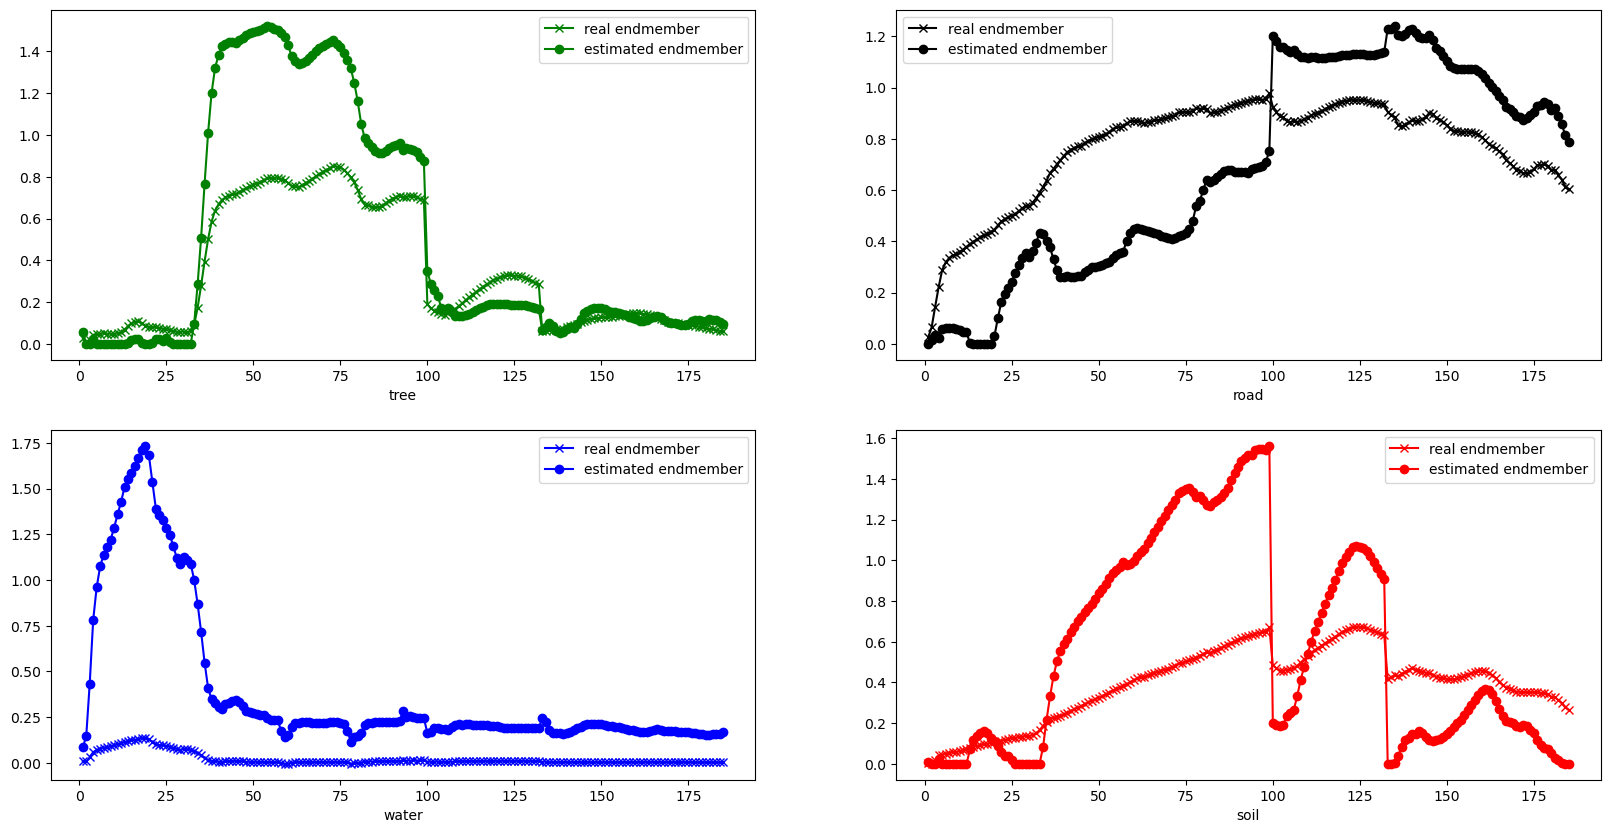

In [47]:
x = np.linspace(1,185,185)

plt.figure(figsize=(9, 3))

fig, axs = plt.subplots(2,2,figsize=(20, 10))
#fig.suptitle('Endmember Plots')

x = np.linspace(1,185,185)

axs[0,0].plot(x,Endmembers[:,0],color='green',marker='x')
axs[0,0].plot(x,nmf_est_endmembers[:,int(sor[0]-1)],color='green',marker='o')
axs[0,0].set_xlabel("tree")
axs[0,0].legend(['real endmember','estimated endmember'])
axs[0,1].plot(x,Endmembers[:,1],color='black',marker='x')
axs[0,1].plot(x,nmf_est_endmembers[:,int(sor[1]-1)],color='black',marker='o')
axs[0,1].set_xlabel("road")
axs[0,1].legend(['real endmember','estimated endmember'])
axs[1,0].plot(x,Endmembers[:,2],color='blue',marker='x')
axs[1,0].plot(x,nmf_est_endmembers[:,int(sor[2]-1)],color='blue',marker='o')
axs[1,0].set_xlabel("water")
axs[1,0].legend(['real endmember','estimated endmember'])
axs[1,1].plot(x,Endmembers[:,3],color='red',marker='x')
axs[1,1].plot(x,nmf_est_endmembers[:,int(sor[3]-1)],color='red',marker='o')
axs[1,1].set_xlabel("soil")

axs[1,1].legend(['real endmember','estimated endmember'])

Text(0.5, 0, 'estimated abundance map of soil')

<Figure size 900x300 with 0 Axes>

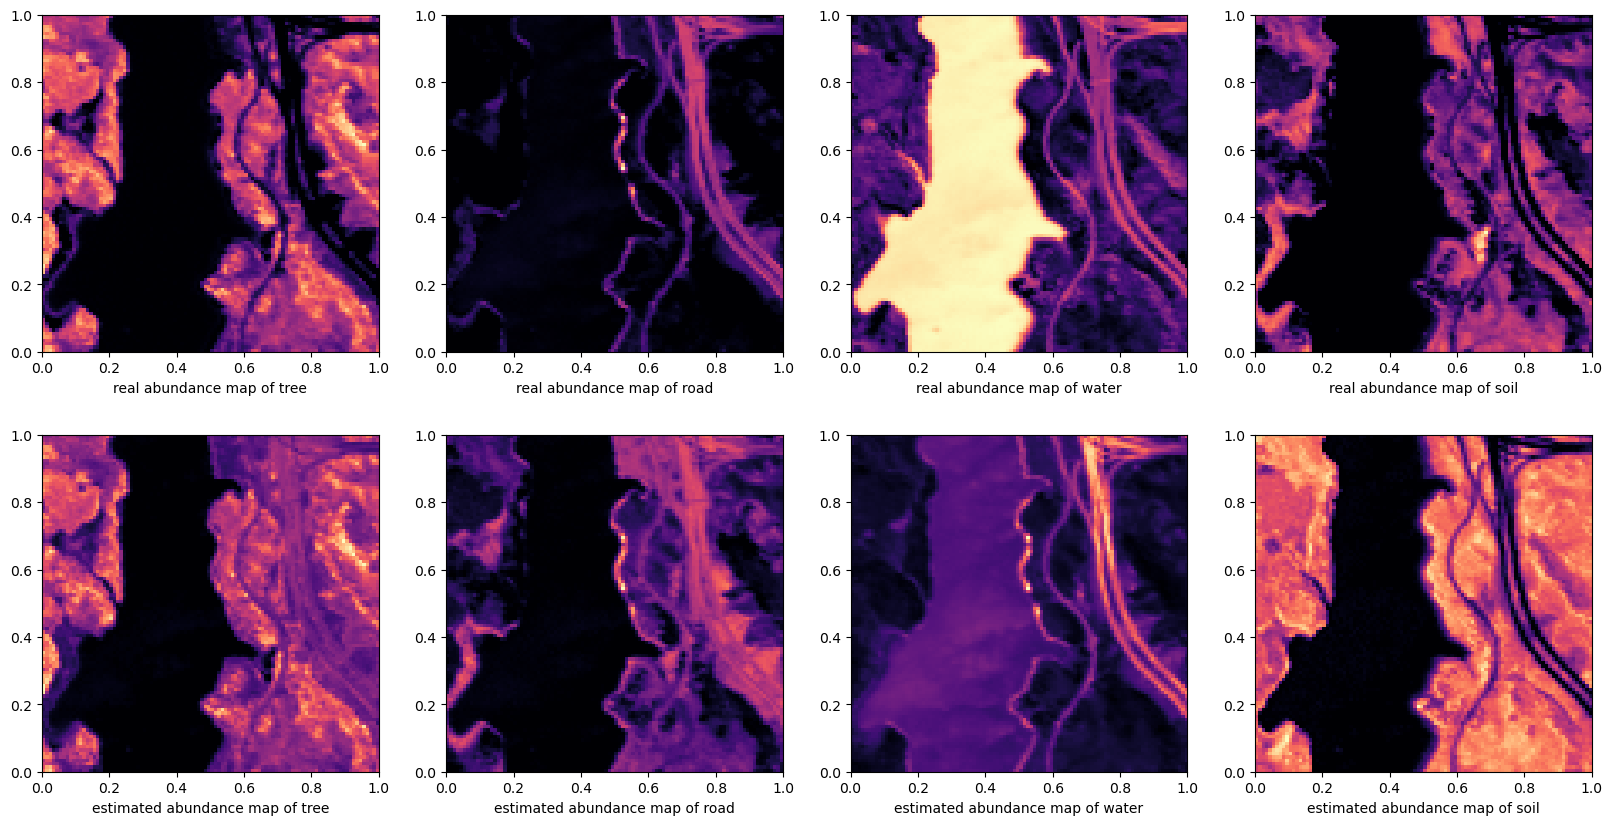

In [46]:
real_abund_tensor=realAbundance.T
est_abund_tensor=np.reshape(a_nmf.T,(int(np.sqrt(a_nmf.T.shape[0])),int(np.sqrt(a_nmf.T.shape[0])),a_nmf.T.shape[1]))
est_abund_tensor=est_abund_tensor
plt.figure(figsize=(9, 3))

fig, axs = plt.subplots(2,4,figsize=(20, 10))
#fig.suptitle('NMF Abundance Maps')
axs[0,0].imshow(real_abund_tensor[:,:,0], extent=[0, 1, 0, 1])
axs[0,0].set_xlabel('real abundance map of tree')
axs[0,1].imshow(real_abund_tensor[:,:,1], extent=[0, 1, 0, 1])
axs[0,1].set_xlabel('real abundance map of road')
axs[0,2].imshow(real_abund_tensor[:,:,2], extent=[0, 1, 0, 1])
axs[0,2].set_xlabel('real abundance map of water')
axs[0,3].imshow(real_abund_tensor[:,:,3], extent=[0, 1, 0, 1])
axs[0,3].set_xlabel('real abundance map of soil')
axs[1,0].imshow(est_abund_tensor[:,:,int(sor[0]-1)].T, extent=[0, 1, 0, 1])
axs[1,0].set_xlabel('estimated abundance map of tree')
axs[1,1].imshow(est_abund_tensor[:,:,int(sor[1]-1)].T, extent=[0, 1, 0, 1])
axs[1,1].set_xlabel('estimated abundance map of road')
axs[1,2].imshow(est_abund_tensor[:,:,int(sor[2]-1)].T, extent=[0, 1, 0, 1])
axs[1,2].set_xlabel('estimated abundance map of water')
axs[1,3].imshow(est_abund_tensor[:,:,int(sor[3]-1)].T, extent=[0, 1, 0, 1])
axs[1,3].set_xlabel('estimated abundance map of soil')

In [ ]:
real_abund_tensor=realAbundance.T
est_abund_tensor=np.reshape(a_nmf.T,(int(np.sqrt(a_nmf.T.shape[0])),int(np.sqrt(a_nmf.T.shape[0])),a_nmf.T.shape[1]))
real_abund_tensor.shape